# Convolutional Auto-Encoder

In [1]:
import torch
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: x.to(device))
])
trn_ds = MNIST('data-normalized',transform = img_transform, train=True, download=False)
val_ds = MNIST('data-normalized', transform=img_transform, train=False, download=False)
batch_size = 256
trn_dl = DataLoader(trn_ds,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=batch_size, shuffle=False)

In [3]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,3,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,5,stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,2,stride=2,padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
model = ConvAutoEncoder().to(device)
summary(model, torch.zeros(2,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 3, 3]            --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          320
|    └─ReLU: 2-2                         [-1, 32, 14, 14]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 7, 7]            --
|    └─Conv2d: 2-4                       [-1, 64, 4, 4]            18,496
|    └─ReLU: 2-5                         [-1, 64, 4, 4]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 3, 3]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 7, 7]            18,464
|    └─ReLU: 2-8                         [-1, 32, 7, 7]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 3, 3]            --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          320
|    └─ReLU: 2-2                         [-1, 32, 14, 14]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 7, 7]            --
|    └─Conv2d: 2-4                       [-1, 64, 4, 4]            18,496
|    └─ReLU: 2-5                         [-1, 64, 4, 4]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 3, 3]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 7, 7]            18,464
|    └─ReLU: 2-8                         [-1, 32, 7, 7]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [5]:
def train_batch(model,input,loss_fn,optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output,input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def val_batch(model,input,loss_fn):
    model.eval()
    output = model(input)
    loss = loss_fn(output,input)
    return loss



In [6]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001, weight_decay=1e-5)

In [7]:
num_epochs = 5
log = Report(num_epochs)

In [8]:
N_trn = len(trn_dl)
N_val = len(val_dl)
for epoch in range(num_epochs):
    for idx, (data, _) in enumerate(trn_dl):
        loss = train_batch(model,data,loss_fn,optimizer)
        log.record(pos=(epoch+(idx+1)/N_trn), trn_loss=loss, end="\r")
    for idx, (data, _) in enumerate(val_dl):
        loss = val_batch(model,data, loss_fn)
        log.record(pos=(epoch+(idx+1)/N_val), val_loss = loss, end='\r')
    log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.085  trn_loss: 0.265  (10.15s - 40.59s remaining)
EPOCH: 2.000  val_loss: 0.049  trn_loss: 0.063  (19.88s - 29.82s remaining)
EPOCH: 3.000  val_loss: 0.038  trn_loss: 0.044  (30.35s - 20.23s remaining)
EPOCH: 4.000  val_loss: 0.033  trn_loss: 0.037  (40.77s - 10.19s remaining)
EPOCH: 5.000  val_loss: 0.030  trn_loss: 0.032  (51.24s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 8204.24it/s]


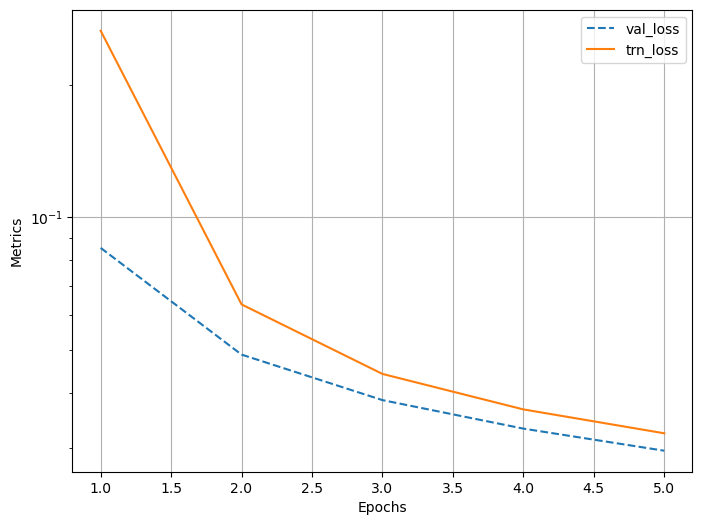

In [9]:
log.plot_epochs(log=True)

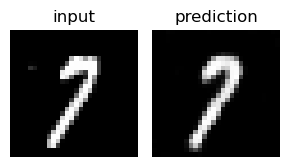

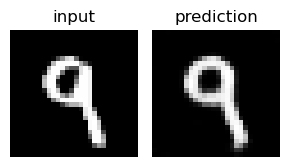

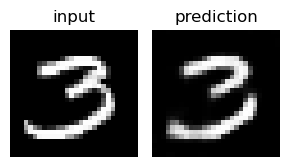

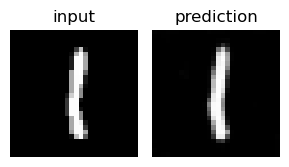

In [10]:
for _ in range(4):
    idx = np.random.randint(len(val_ds))
    im, _ = val_ds[idx]
    im_pred = model(im[None])[0] # equivalent to im.unsqueeze(0)
    fig, ax = plt.subplots(1,2, figsize=(3,3))
    show(im[0],ax=ax[0], title="input")
    show(im_pred[0], ax=ax[1], title="prediction")
    plt.tight_layout()
    plt.show()

# inspect latent projection

In [55]:
latent_vectors = []
classes = []

In [56]:
for im, label in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(label)

In [57]:
torch.cat(latent_vectors,dim=0).shape

torch.Size([10000, 576])

In [58]:
latent_vectors = torch.cat(latent_vectors,dim=0).cpu().detach().numpy()

In [59]:
from sklearn.manifold import TSNE
tsne = TSNE(2)

In [63]:
clustered = tsne.fit_transform(latent_vectors)


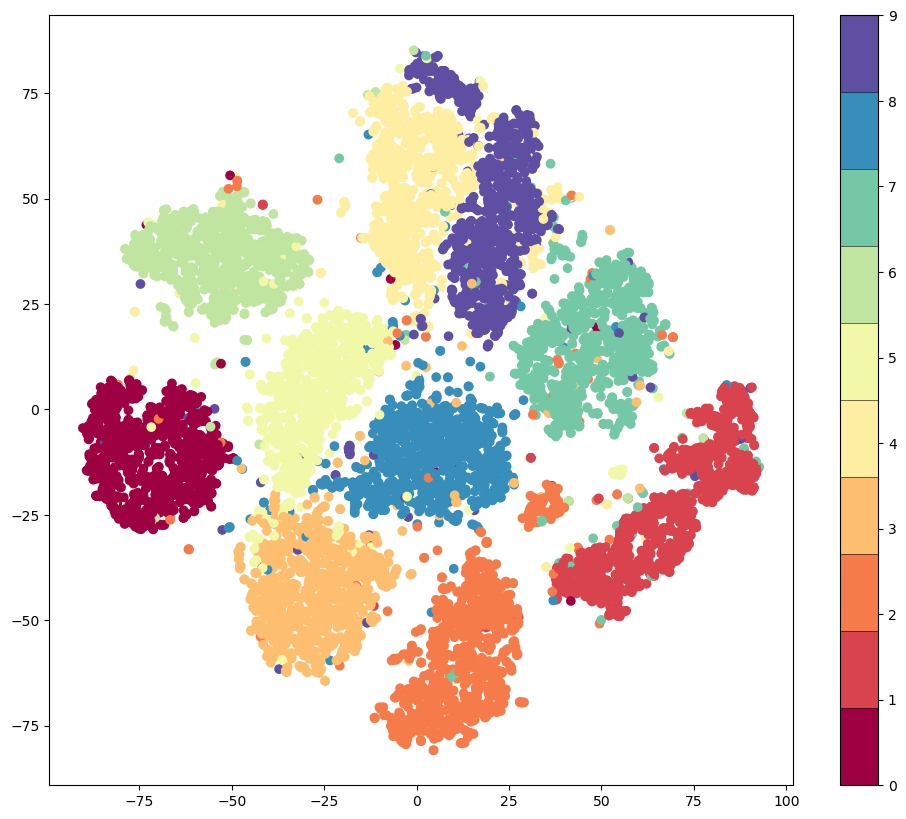

In [78]:
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap("Spectral", 10)
plt.scatter(x=clustered.T[0,:],y=clustered.T[1,:], c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

In [66]:
clustered.shape

(10000, 2)

In [73]:
clustered[:2,:2]

array([[ 46.056488,  11.945475],
       [ 22.373737, -51.53743 ]], dtype=float32)

In [74]:
clustered.T.shape

(2, 10000)

In [75]:
clustered.T[:2,:2]

array([[ 46.056488,  22.373737],
       [ 11.945475, -51.53743 ]], dtype=float32)